# Week 4: Multi-class Classification

Welcome to this assignment! In this exercise, you will get a chance to work on a multi-class classification problem. You will be using the [Sign Language MNIST](https://www.kaggle.com/datamunge/sign-language-mnist) dataset, which contains 28x28 images of hands depicting the 26 letters of the English alphabet.

You will need to pre-process the data so that it can be fed into your convolutional neural network to correctly classify each image as the letter it represents.


Let's get started!

_**NOTE:** To prevent errors from the autograder, please avoid editing or deleting non-graded cells in this notebook . Please only put your solutions in between the `### START CODE HERE` and `### END CODE HERE` code comments, and refrain from adding any new cells._

In [ ]:
# grader-required-cell

import csv
import string
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

Download the training and test sets (the test set will actually be used as a validation set):

In [ ]:
# sign_mnist_train.csv
!gdown --id 1z0DkA9BytlLxO1C0BAWzknLyQmZAp0HR
# sign_mnist_test.csv
!gdown --id 1z1BIj4qmri59GWBG4ivMNFtpZ4AXIbzg

Define some globals with the path to both files you just downloaded:

In [ ]:
# grader-required-cell

TRAINING_FILE = './sign_mnist_train.csv'
VALIDATION_FILE = './sign_mnist_test.csv'

Unlike previous assignments, you will not have the actual images provided, instead you will have the data serialized as `csv` files.

Take a look at how the data looks like within the `csv` file:

In [ ]:
# grader-required-cell

with open(TRAINING_FILE) as training_file:
  line = training_file.readline()
  print(f"First line (header) looks like this:\n{line}")
  line = training_file.readline()
  print(f"Each subsequent line (data points) look like this:\n{line}")

As you can see, each file includes a header (the first line) and each subsequent data point is represented as a line that contains 785 values.

The first value is the label (the numeric representation of each letter) and the other 784 values are the value of each pixel of the image. Remember that the original images have a resolution of 28x28, which sums up to 784 pixels.

 ## Parsing the dataset

 Now complete the `parse_data_from_input` below.

 This function should be able to read a file passed as input and return 2 numpy arrays, one containing the labels and one containing the 28x28 representation of each image within the file. These numpy arrays should have type `float64`.

 A couple of things to keep in mind:

- The first line contains the column headers, so you should ignore it.

- Each successive line contains 785 comma-separated values between 0 and 255
  - The first value is the label

  - The rest are the pixel values for that picture

  
**Hint**:

You have two options to solve this function.
  
   - 1. One is to use `csv.reader` and create a for loop that reads from it, if you take this approach take this into consideration:

        - `csv.reader` returns an iterable that returns a row of the csv file in each iteration.
    Following this convention, row[0] has the label and row[1:] has the 784 pixel values.

        - To reshape the arrays (going from 784 to 28x28), you can use functions such as [`np.array_split`](https://numpy.org/doc/stable/reference/generated/numpy.array_split.html) or [`np.reshape`](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html).

        - For type conversion of the numpy arrays, use the method [`np.ndarray.astype`](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.astype.html).


   - 2. The other one is to use `np.loadtxt`. You can find the documentation [here](https://numpy.org/doc/stable/reference/generated/numpy.loadtxt.html).
   
   
Regardless of the method you chose, your function should finish its execution in under 1 minute. If you see that your function is taking a long time to run, try changing your implementation.

In [ ]:
# grader-required-cell

# GRADED FUNCTION: parse_data_from_input
def parse_data_from_input(filename):
  """
  Parses the images and labels from a CSV file

  Args:
    filename (string): path to the CSV file

  Returns:
    images, labels: tuple of numpy arrays containing the images and labels
  """
  with open(filename) as file:
    ### START CODE HERE

    # Use csv.reader, passing in the appropriate delimiter
    # Remember that csv.reader can be iterated and returns one line in each iteration
    csv_reader = csv.reader(file, delimiter=None)

    labels = None
    images = None


    ### END CODE HERE

    return images, labels

In [ ]:
# grader-required-cell

# Test your function
training_images, training_labels = parse_data_from_input(TRAINING_FILE)
validation_images, validation_labels = parse_data_from_input(VALIDATION_FILE)

print(f"Training images has shape: {training_images.shape} and dtype: {training_images.dtype}")
print(f"Training labels has shape: {training_labels.shape} and dtype: {training_labels.dtype}")
print(f"Validation images has shape: {validation_images.shape} and dtype: {validation_images.dtype}")
print(f"Validation labels has shape: {validation_labels.shape} and dtype: {validation_labels.dtype}")

**Expected Output:**
```
Training images has shape: (27455, 28, 28) and dtype: float64
Training labels has shape: (27455,) and dtype: float64
Validation images has shape: (7172, 28, 28) and dtype: float64
Validation labels has shape: (7172,) and dtype: float64
```

## Visualizing the numpy arrays

Now that you have converted the initial csv data into a format that is compatible with computer vision tasks, take a moment to actually see how the images of the dataset look like:

In [ ]:
# Plot a sample of 10 images from the training set
def plot_categories(training_images, training_labels):
  fig, axes = plt.subplots(1, 10, figsize=(16, 15))
  axes = axes.flatten()
  letters = list(string.ascii_lowercase)

  for k in range(10):
    img = training_images[k]
    img = np.expand_dims(img, axis=-1)
    img = array_to_img(img)
    ax = axes[k]
    ax.imshow(img, cmap="Greys_r")
    ax.set_title(f"{letters[int(training_labels[k])]}")
    ax.set_axis_off()

  plt.tight_layout()
  plt.show()

plot_categories(training_images, training_labels)

## Creating the generators for the CNN

Now that you have successfully organized the data in a way that can be easily fed to Keras' `ImageDataGenerator`, it is time for you to code the generators that will yield batches of images, both for training and validation. For this complete the `train_val_generators` function below.

Some important notes:

- The images in this dataset come in the same resolution so you don't need to set a custom `target_size` in this case. In fact, you can't even do so because this time you will not be using the `flow_from_directory` method (as in previous assignments). Instead you will use the [`flow`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow) method.
- You need to add the "color" dimension to the numpy arrays that encode the images. These are black and white images, so this new dimension should have a size of 1 (instead of 3, which is used when dealing with colored images). Take a look at the function [`np.expand_dims`](https://numpy.org/doc/stable/reference/generated/numpy.expand_dims.html) for this.

In [81]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Function to create and return data generators
def train_val_generators(training_images, training_labels, validation_images, validation_labels):
    # Define data augmentation for the training data
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Define data augmentation for the validation data (optional)
    validation_datagen = ImageDataGenerator(rescale=1./255)

    # Convert validation_images to a NumPy array
    validation_images = np.array(validation_images)

    # Reshape the training and validation data to rank-4 tensors
    training_images = training_images.reshape(-1, 28, 28, 1)
    validation_images = validation_images.reshape(-1, 28, 28, 1)

    # Create the training generator
    train_generator = train_datagen.flow(
        x=training_images,
        y=training_labels,
        batch_size=32,
        shuffle=True  # You can set this to True if you want to shuffle the data
    )

    # Create the validation generator
    validation_generator = validation_datagen.flow(
        x=validation_images,
        y=validation_labels,
        batch_size=32,
        shuffle=False  # Validation data should not be shuffled
    )

    return train_generator, validation_generator

In [82]:
# grader-required-cell

# Test your generators
train_generator, validation_generator = train_val_generators(training_images, training_labels, validation_images, validation_labels)

print(f"Images of training generator have shape: {train_generator.x.shape}")
print(f"Labels of training generator have shape: {train_generator.y.shape}")
print(f"Images of validation generator have shape: {validation_generator.x.shape}")
print(f"Labels of validation generator have shape: {validation_generator.y.shape}")

Images of training generator have shape: (27455, 28, 28, 1)
Labels of training generator have shape: (27455,)
Images of validation generator have shape: (7172, 28, 28, 1)
Labels of validation generator have shape: (7172,)


**Expected Output:**
```
Images of training generator have shape: (27455, 28, 28, 1)
Labels of training generator have shape: (27455,)
Images of validation generator have shape: (7172, 28, 28, 1)
Labels of validation generator have shape: (7172,)
```

## Coding the CNN

One last step before training is to define the architecture of the model.

Complete the `create_model` function below. This function should return a Keras' model that uses the `Sequential` or the `Functional` API.

The last layer of your model should have a number of units equal to the number of letters in the English alphabet. It should also use an activation function that will output the probabilities per letter.

*Note: The [documentation](https://www.kaggle.com/datamunge/sign-language-mnist) of the dataset mentions that there are actually no cases for the last letter, Z, and this will allow you to reduce the recommended number of output units above by one. If you're not yet convinced, you can safely ignore this fact for now and study it later. You will pass the assignment even without this slight optimization.*

Aside from defining the architecture of the model, you should also compile it so make sure to use a `loss` function that is suitable for multi-class classification.

**Note that you should use no more than 2 Conv2D and 2 MaxPooling2D layers to achieve the desired performance.**

In [84]:
import tensorflow as tf

def create_model():
    # Define the model
    # Use no more than 2 Conv2D and 2 MaxPooling2D
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(26, activation='softmax')  # 26 output classes (letters A to Z)
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',  # Loss for classification
                  metrics=['accuracy'])

    return model

# Create an instance of the model
model = create_model()

# Summary of the model architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 13, 13, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dense_2 (Dense)             (None, 512)              

In [77]:
# Save your model
model = create_model()

# Train your model
history = model.fit(train_generator,
                    epochs=15,
                    validation_data=validation_generator)

Epoch 1/15
858/858 [==============================] - 72s 83ms/step - loss: 2.6127 - accuracy: 0.1979 - val_loss: 1.5596 - val_accuracy: 0.4596
Epoch 2/15
858/858 [==============================] - 69s 80ms/step - loss: 1.7452 - accuracy: 0.4465 - val_loss: 1.0702 - val_accuracy: 0.6280
Epoch 3/15
858/858 [==============================] - 70s 82ms/step - loss: 1.3438 - accuracy: 0.5573 - val_loss: 0.7333 - val_accuracy: 0.7434
Epoch 4/15
858/858 [==============================] - 69s 80ms/step - loss: 1.0958 - accuracy: 0.6361 - val_loss: 0.5423 - val_accuracy: 0.8031
Epoch 5/15
858/858 [==============================] - 69s 80ms/step - loss: 0.9242 - accuracy: 0.6963 - val_loss: 0.5728 - val_accuracy: 0.7861
Epoch 6/15
858/858 [==============================] - 68s 79ms/step - loss: 0.8214 - accuracy: 0.7273 - val_loss: 0.3481 - val_accuracy: 0.8744
Epoch 7/15
858/858 [==============================] - 70s 82ms/step - loss: 0.7153 - accuracy: 0.7604 - val_loss: 0.4122 - val_accuracy:

Now take a look at your training history:

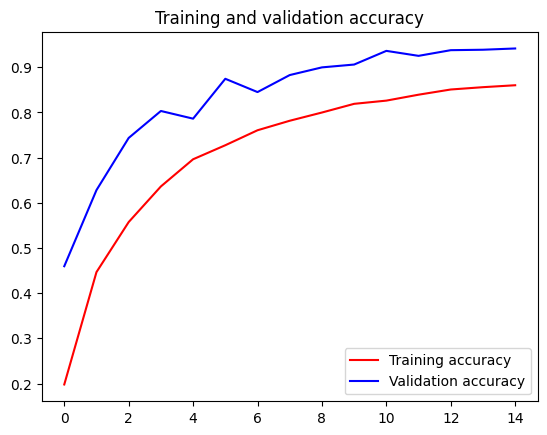

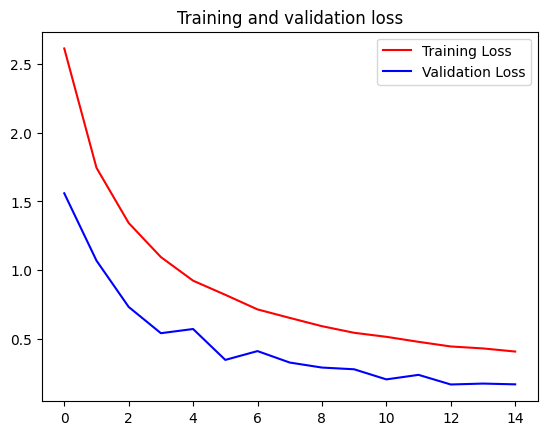

In [85]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

You will not be graded based on the accuracy of your model but try making it as high as possible for both training and validation, as an optional exercise, **after submitting your notebook for grading**.

A reasonable benchmark is to achieve over 99% accuracy for training and over 95% accuracy for validation within 15 epochs. Try tweaking your model's architecture or the augmentation techniques to see if you can achieve these levels of accuracy.

## Download your notebook for grading

You will need to submit your solution notebook for grading. The following code cells will check if this notebook's grader metadata (i.e. hidden data in the notebook needed for grading) is not modified by your workspace. This will ensure that the autograder can evaluate your code properly. Depending on its output, you will either:

* *if the metadata is intact*: Download the current notebook. Click on the File tab on the upper left corner of the screen then click on `Download -> Download .ipynb.` You can name it anything you want as long as it is a valid `.ipynb` (jupyter notebook) file.
<br>

* *if the metadata is missing*: A new notebook with your solutions will be created on this Colab workspace. It should be downloaded automatically and you can submit that to the grader.

In [87]:
# Download metadata checker
!wget -nc https://storage.googleapis.com/tensorflow-1-public/colab_metadata_checker.py

--2023-10-05 15:11:33--  https://storage.googleapis.com/tensorflow-1-public/colab_metadata_checker.py
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.212.207, 142.251.162.207, 173.194.215.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.212.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1997 (2.0K) [text/x-python-script]
Saving to: ‘colab_metadata_checker.py’

colab_metadata_chec 100%[===================>]   1.95K  --.-KB/s    in 0s      

2023-10-05 15:11:33 (35.0 MB/s) - ‘colab_metadata_checker.py’ saved [1997/1997]



In [88]:
import colab_metadata_checker

# Please see the output of this cell to see which file you need to submit to the grader
colab_metadata_checker.run('C2W4_Assignment_fixed.ipynb')

Grader metadata detected! You can download this notebook by clicking `File > Download > Download as .ipynb` and submit it to the grader!


**Please disregard the following note if the notebook metadata is detected**

_Note: Just in case the download fails for the second point above, you can also do these steps:_
* _Click the Folder icon on the left side of this screen to open the File Manager._
* _Click the Folder Refresh icon in the File Manager to see the latest files in the workspace. You should see a file ending with a `_fixed.ipynb`._
* _Right-click on that file to save locally and submit it to the grader._


**Congratulations on finishing this week's assignment!**

You have successfully implemented a convolutional neural network that is able to perform multi-class classification tasks! Nice job!

**Keep it up!**